[Check out this notebook](https://www.kaggle.com/shihabshahriar/pytorch-movielens)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])
df.head()

,userId,movieId,rating
0,0,0,3
1,1,1,3
2,2,2,1
3,3,3,2
4,4,4,1


In [4]:
df.shape

(100000, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 943
Number of items: 1682
Min item rating: 1
Max item rating: 5
Mean item rating: 3.52986


In [6]:
class TabularDataset(Dataset):
    """Tabular dataset from pandas DataFrame"""

    def __init__(self, X, y):
        """
        Args:
            X (array): Features
            y (array): Response
        """
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = torch.tensor(self.X[idx,:]).long().to(device)
        response = torch.tensor(self.y[idx]).float().to(device)
        sample = (features, response)
        
        return sample

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values, df.rating.values,
                                                    test_size=.1,
                                                    random_state=42)

In [8]:
train = TabularDataset(X_train, y_train)
test = TabularDataset(X_test, y_test)

trainloader = DataLoader(train, batch_size=32)
testloader = DataLoader(test, batch_size=32)

In [9]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.user_em = nn.Embedding(df.userId.nunique(), 25)
        self.item_em = nn.Embedding(df.movieId.nunique(), 25)

    def forward(self, user, item):
        user_em = self.user_em(user)
        item_em = self.item_em(item)
        dot = (user_em * item_em).sum(1)
        return torch.sigmoid(dot) * 4 + 1

In [10]:
net = Net()
net.to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(10):  # loop over the dataset multiple times
    
    # turns on drouput
    net.train()

    running_loss = 0.0
    for data in tqdm(trainloader):
        inputs, labels = data
        users = inputs[:,0]
        items = inputs[:,1]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(users, items)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        
        # turn off dropout
        net.eval()
        inputs, labels = iter(testloader).next()
        users = inputs[:,0]
        items = inputs[:,1]
        outputs = net(users, items)
        loss = criterion(outputs, labels)
        print(f'Test loss: {np.sqrt(loss.item()):.3f}')
    

print('Finished Training')


Test loss: 1.169



Test loss: 1.168



Test loss: 1.159



Test loss: 1.141



Test loss: 1.135



Test loss: 1.129



Test loss: 1.139



Test loss: 1.138



Test loss: 1.141



Test loss: 1.130
Finished Training


In [21]:
y_pred = []
y_true = []

# turn off gradients for validation, saves memory and computations
with torch.no_grad():
    
    for data in tqdm(testloader):
        inputs, labels = data
        users = inputs[:,0]
        items = inputs[:,1]
        outputs = net(users, items).cpu().numpy()
        
        y_pred = np.hstack((y_pred, outputs))
        y_true = np.hstack((y_true, labels.cpu().numpy()))

In [23]:
np.sqrt(np.mean((y_pred - y_true)**2))

1.9883577902797434

In [24]:
y_pred

array([1.00085151, 1.00455177, 1.00018883, ..., 1.50688863, 4.99810934,
       1.00217891])

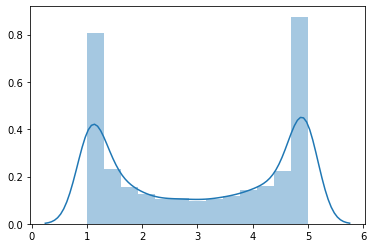

In [26]:
sns.distplot(y_pred)